# Next Word Prediction:

### Importing The Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
"""
    Dataset: http://www.gutenberg.org/cache/epub/5200/pg5200.txt
    Remove all the unnecessary data and label it as Metamorphosis-clean.
    The starting and ending lines should be as follows.

"""


file = open('../nlp_datasets/Metamorphosis_Franz_Kafka.txt', "r", encoding = "utf8")

#file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿The Project Gutenberg EBook of Metamorphosis, by Franz Kafka

The Last Line:  subscribe to our email newsletter to hear about new eBooks.



### Cleaning the data:

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'The Project Gutenberg EBook of Metamorphosis, by Franz Kafka Translated by David Wyllie.  This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org  ** This is a COPYRIG'

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'The Project Gutenberg EBook of Metamorphosis  by Franz Kafka Translated by David Wyllie   This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever   You may copy it  give it away or re use it under the terms of the Project Gutenberg License included with this eBook or online at www gutenberg org     This is a COPYRIGHTED Project Gutenberg eBook  Details Below           Please follow the copyright guidelines in this file           Title  Metamorphosis  Au'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'The Project Gutenberg EBook of Metamorphosis, by Franz Kafka Translated David Wyllie. This eBook is for the use anyone anywhere at no cost and with almost restrictions whatsoever. You may copy it, give it away or re-use under terms License included this online www.gutenberg.org ** a COPYRIGHTED eBook, Details Below Please follow copyright guidelines in file. Title: Metamorphosis Author: Translator: Wyllie Release Date: August 16, 2005 [EBook #5200] First posted: May 13, 2002 Last updated: 20, 20'

### Tokenization:

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[20, 175, 2, 50, 51, 176, 356, 882, 883, 884]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3068


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  4714


array([[ 20, 175],
       [175,   2],
       [  2,  50],
       [ 50,  51],
       [ 51, 176],
       [176, 356],
       [356, 882],
       [882, 883],
       [883, 884],
       [884, 885]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 20 175   2  50  51]
The responses are:  [175   2  50  51 176]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Creating the Model:

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
#model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(16, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 10)             30680     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3068)              52156     
Total params: 84,836
Trainable params: 84,836
Non-trainable params: 0
_________________________________________________________________


### Plot The Model:

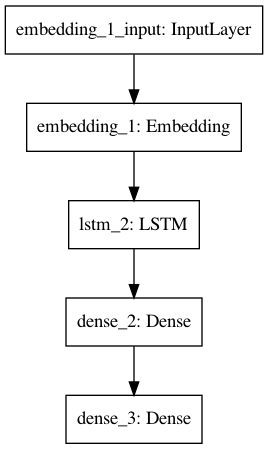

In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile The Model:

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

### Fit The Model:

In [20]:
history=model.fit(X, y, epochs=10, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/10
63/74 [========================>.....] - ETA: 0s - loss: 7.1816
Epoch 00001: loss improved from 7.23590 to 7.18953, saving model to nextword1.h5
74/74 [==============================] - 0s 4ms/step - loss: 7.1895
Epoch 2/10
63/74 [========================>.....] - ETA: 0s - loss: 7.1498
Epoch 00002: loss improved from 7.18953 to 7.15469, saving model to nextword1.h5
74/74 [==============================] - 0s 4ms/step - loss: 7.1547
Epoch 3/10
71/74 [===========================>..] - ETA: 0s - loss: 7.1199
Epoch 00003: loss improved from 7.15469 to 7.12259, saving model to nextword1.h5
74/74 [==============================] - 0s 3ms/step - loss: 7.1226
Epoch 4/10
67/74 [==========================>...] - ETA: 0s - loss: 7.0910
Epoch 00004: loss improved from 7.12259 to 7.09005, saving model to nextword1.h5
74/74 [==============================] - 0s 3ms/step - loss: 7.0900
Epoch 5/10
71/74 [===========================>..] - ETA: 0s - loss: 7.0498
Epoch 00005: loss improved fr

### Graph:

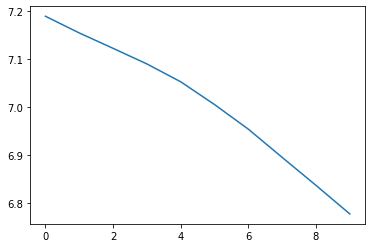

In [22]:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# tensorboard --logdir="./logsnextword1"
# http://DESKTOP-U3TSCVT:6006/

#from IPython.display import Image 
#pil_img = Image(filename='graph1.png')
#display(pil_img)
import pylab as plt
plt.plot(history.history['loss'])

## Observation:
### We are able to develop a decent next word prediction model and are able to get a declining loss and an overall decent performance.